In [1]:
from floorplan import Box, Net, FloorPlan
# import cvxpy as cp
# from cvxpy import Variable, Constant, Minimize, Problem
# import placedb
# import pylab
# import math
import joblib
# from sklearn.manifold import SpectralEmbedding
# import scipy.io as io
# import scipy.sparse.csgraph as csgraph
# import jax
# from jax import jit, vmap, random, grad
# from jax.example_libraries import optimizers
# from jax import numpy as jnp
# from functools import partial
# import itertools
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
# from matplotlib import collections as mc
# # import datetime
# from tqdm.notebook import tqdm
import os

%load_ext autoreload
%autoreload 2

## Setup

In [2]:
# Custom KiCAD package
from ucsdpcb import pcbnew
# but this is before reading the board
print(pcbnew.DEFAULT_LINE_WIDTH)
print(pcbnew.DEFAULT_SILK_LINE_WIDTH)
print(pcbnew.DEFAULT_COPPER_LINE_WIDTH)

0.1
0.1
0.2


In [3]:
numCores = joblib.cpu_count()
PCB_DIR = 'PCBBenchmarks/bm9'
PCB_NAME = 'bm9.routed.kicad_pcb'
# PCB_DIR = 'PCBBenchmarks/test'
# PCB_NAME = 'output.allegro.kicad_pcb'
PCB_PATH = os.path.join(PCB_DIR, PCB_NAME)

# Load the PCB
board = pcbnew.LoadBoard(PCB_PATH)

In [4]:
# Now I now the position of each components
print(len(board.GetFootprints()))
ftpt = board.GetFootprints()[0]
# ftpt.GetBoundingBox().GetHeight()
print(ftpt.GetDescription())
print(ftpt.GetFPID())
print(ftpt.GetFPIDAsString())
print(ftpt.GetPadCount())
# same
print(ftpt.GetTypeDesc())
print(ftpt.GetFriendlyName())
# these are all the same
print(ftpt.GetFocusPosition()/1000000.0)
print(ftpt.GetCenter())

8
<b>CAPACITOR</b><p>
<ucsdpcb.pcbnew.LIB_ID; proxy of <Swig Object of type 'LIB_ID *' at 0x7f82993a4600> >
imu:C0805
2
Footprint
Footprint
(150, 101)
(149606000, 100863400)


In [5]:
# there are slight impreceision
ftpt = board.GetFootprints()[0]
print(ftpt.GetBoundingBox().GetWidth()/1e6)
print(ftpt.GetBoundingBox().GetHeight()/1e6)
print(360 + ftpt.GetOrientation().AsDegrees() if ftpt.GetOrientation().AsDegrees() < 0 else ftpt.GetOrientation().AsDegrees())
print(ftpt.GetOrientationDegrees(), ftpt.GetOrientation().AsDegrees())
# print(ftpt.IsLocked())
# print(ftpt.IsFlipped())
# print(ftpt.IsPlaced())
# print(ftpt.GetAttributes())
# print(ftpt.GetLayer())
# print(ftpt.GetLayerName())  
# print(ftpt.GetParentFootprint())
# print(ftpt.GetLocalClearance())
# print(ftpt.GetLocalSolderMaskMargin())
# print(ftpt.GetEffectiveShape().BBox().GetWidth()/1e6)
# print(ftpt.GetEffectiveShape().BBox().GetHeight()/1e6)
# print(ftpt.GetBoundingHull().COutline(0).Width())
# print(ftpt.GetBoundingHull().CHole(0, 1).Width()/1e6)
print(ftpt.GetBoundingHull().OutlineCount())
print(ftpt.GetBoundingHull().Outline(0).SegmentCount())
# ftpt.GetBoundingHull().Outline(0).Width()
# ftpt.GetBoundingHull().Hole(0,0).Width() # keeps changing??
print(ftpt.GetFpPadsLocalBbox().GetWidth()/1e6)
print(ftpt.GetFpPadsLocalBbox().GetHeight()/1e6)
abs(ftpt.GetBoundingBox().GetTop() - ftpt.GetBoundingBox().GetBottom() )/1e6
ftpt.GetBoundingBox().GetSize()

# dir(ftpt)
# dir(ftpt.GetBoundingBox())


2.0124
3.99
270.0
-90.0 -90.0
1
12
3.2
1.5


VECTOR2I(0, 0)

In [10]:
for d in board.GetDrawings():
    print(d.GetPolyShape())
    # print(dir(d))

for f in board.GetFootprints():
    print(f)

# try to get EDA_SHAPE

<ucsdpcb.pcbnew.SHAPE_POLY_SET; proxy of <Swig Object of type 'std::shared_ptr< SHAPE_POLY_SET > *' at 0x7f829959bf30> >
<ucsdpcb.pcbnew.SHAPE_POLY_SET; proxy of <Swig Object of type 'std::shared_ptr< SHAPE_POLY_SET > *' at 0x7f829959bf30> >
<ucsdpcb.pcbnew.SHAPE_POLY_SET; proxy of <Swig Object of type 'std::shared_ptr< SHAPE_POLY_SET > *' at 0x7f829959bf30> >
<ucsdpcb.pcbnew.SHAPE_POLY_SET; proxy of <Swig Object of type 'std::shared_ptr< SHAPE_POLY_SET > *' at 0x7f829959bf30> >
<ucsdpcb.pcbnew.FOOTPRINT; proxy of <Swig Object of type 'std::deque< FOOTPRINT * >::value_type' at 0x7f828d4d18a0> >
<ucsdpcb.pcbnew.FOOTPRINT; proxy of <Swig Object of type 'std::deque< FOOTPRINT * >::value_type' at 0x7f828d4d1cf0> >
<ucsdpcb.pcbnew.FOOTPRINT; proxy of <Swig Object of type 'std::deque< FOOTPRINT * >::value_type' at 0x7f828d4d1ba0> >
<ucsdpcb.pcbnew.FOOTPRINT; proxy of <Swig Object of type 'std::deque< FOOTPRINT * >::value_type' at 0x7f828d4d1750> >
<ucsdpcb.pcbnew.FOOTPRINT; proxy of <Swig Ob

## Helper functions
- New PCBNEW API does not behave like the original code. These function is a workaround

In [4]:
def getAngle(ftpt):
    """Get the angle of the footprint"""
    return (
        360 + ftpt.GetOrientation().AsDegrees()
        if ftpt.GetOrientation().AsDegrees() < 0
        else ftpt.GetOrientation().AsDegrees()
    )

def getX(ftpt):
    """Get the x coordinate of the footprint"""
    return ftpt.GetCenter()[0] / 1e6

def getY(ftpt):
    """Get the y coordinate of the footprint"""
    return ftpt.GetCenter()[1] / 1e6

def getBBoxWidth(ftpt, line_width=0):
    """Get the width of the bounding box of the footprint"""
    angle = getAngle(ftpt)
    # depends on the orientation, flip the width and height
    if angle == 0 or angle == 180:
        return ftpt.GetBoundingBox().GetWidth() / 1e6 + line_width
    elif angle == 90 or angle == 270:
        return ftpt.GetBoundingBox().GetHeight() / 1e6 + line_width
    else:
        raise Exception("[ERROR ]Angle not supported")
    # return ftpt.GetBoundingBox().GetWidth() / 1e6
    
def getBBoxHeight(ftpt, line_width=0):
    """Get the height of the bounding box of the footprint"""
    angle = getAngle(ftpt)
    # depends on the orientation, flip the width and height
    if angle == 0 or angle == 180:
        return ftpt.GetBoundingBox().GetHeight() / 1e6 + line_width
    elif angle == 90 or angle == 270:
        return ftpt.GetBoundingBox().GetWidth() / 1e6 + line_width
    else:
        raise Exception("[ERROR ]Angle not supported")
    # return ftpt.GetBoundingBox().GetHeight() / 1e6
    
def getPadHashName(instID, padID):
    """Get the hash name of the pad"""
    return f"{instID}:{padID}"

### Gather rotation and coordinates of components

In [5]:
VERBOSE = True

# reset
sumarea = 0
movable = []
compX = []
compY = []
compW = []
compH = []
maxx = 0
maxy = 0
minx = 99999999
miny = 99999999
init_Rotation = []
init_Mirror = []

# TODO: I do not know how to get the width of fp_poly, so currently manually set it
FP_POLY_WIDTH_DICT = {
    "U1":0.05,
    "U2":0.05,
    "U3":0.05,
    "U4":0.05,
    "U5":0.1,
    "U6":0.1,
    "U7":0.1,
    "U8":0.1,
}

# gather rotation and coordinates of components
for i in range(len(board.GetFootprints())):
    inst = board.GetFootprints()[i]
    # print(dir(inst))
    angle = getAngle(inst)

    # if inst Pad count exceeds 40, then lock it
    # if inst.GetPadCount() > 40:
    #     inst.SetLocked(True)

    # get the poly
    poly = inst.GetBoundingHull()
    # print poly
    # print (dir(poly))
    # print("AREA: ", poly.Area()) if VERBOSE else None
    # print("BBOX: ", poly.BBox().GetWidth()) if VERBOSE else None

    # print inst name
    print("inst name: {}".format(inst.GetReference())) if VERBOSE else None
    instName = inst.GetReference()
    # mannually lock CLK components
    # if instName == "RA57" or instName == "RA36":
    #     inst.SetLocked(True)
    #     print("     locked") if VERBOSE else None

    if inst.IsLocked():
        movable.append(False)
    else:
        movable.append(True)
    if angle == 0:
        init_Rotation.append(False)
        init_Mirror.append(False)
    elif angle == 90:
        init_Rotation.append(True)
        init_Mirror.append(False)
    elif angle == 180:
        init_Rotation.append(False)
        init_Mirror.append(True)
    elif angle == 270:
        init_Rotation.append(True)
        init_Mirror.append(True)
    bboxWidth = getBBoxWidth(inst, line_width=FP_POLY_WIDTH_DICT[instName])
    bboxHeight = getBBoxHeight(inst, line_width=FP_POLY_WIDTH_DICT[instName])

    print(str(i) + " => getCompBBoxW " + str(bboxWidth)) if VERBOSE else None
    print("     getCompBBoxH " + str(bboxHeight)) if VERBOSE else None
    compX.append(
        getX(inst)
        - 0.5
        * (
            (1 - int(init_Rotation[-1])) * bboxWidth
            + (int(init_Rotation[-1])) * bboxHeight
        )
    )
    compY.append(
        getY(inst)
        - 0.5
        * (
            (1 - int(init_Rotation[-1])) * bboxHeight
            + (int(init_Rotation[-1])) * bboxWidth
        )
    )
    compW.append(bboxWidth)
    compH.append(bboxHeight)

    if compX[-1] < minx:
        minx = compX[-1]
    if compY[-1] < miny:
        miny = compY[-1]

    if compX[-1] + compH[-1] > maxx:
        maxx = compX[-1] + compH[-1]
    if compY[-1] + compW[-1] > maxy:
        maxy = compY[-1] + compW[-1]

    print(
        "     index: {} x: {} y: {} w: {} h: {}".format(
            i, compX[-1], compY[-1], compW[-1], compH[-1]
        )
    ) if VERBOSE else None
    print(
        "     angle: {} init_Rotation: {} init_Mirror: {}".format(
            angle, init_Rotation[-1], init_Mirror[-1]
        )
    ) if VERBOSE else None
    print("     getPadCount: {}".format(inst.GetPadCount())) if VERBOSE else None
    print("") if VERBOSE else None

    sumarea += bboxWidth * bboxHeight
print("util: {}".format(sumarea / ((maxx - minx) * (maxy - miny))))
print("num nodes: {} ({} movable)".format(len(compX), len([m for m in movable if m])))

# enlarge the boarder
maxx *= 2
maxy *= 2

# print max and min
print("[INFO] maxx: {} maxy: {}".format(maxx, maxy))
print("[INFO] minx: {} miny: {}".format(minx, miny))

inst name: U1
0 => getCompBBoxW 4.04
     getCompBBoxH 2.0624
     index: 0 x: 148.57479999999998 y: 98.8434 w: 4.04 h: 2.0624
     angle: 270.0 init_Rotation: True init_Mirror: True
     getPadCount: 2

inst name: U2
1 => getCompBBoxW 4.04
     getCompBBoxH 2.0624
     index: 1 x: 150.8354 y: 98.8434 w: 4.04 h: 2.0624
     angle: 270.0 init_Rotation: True init_Mirror: True
     getPadCount: 2

inst name: U3
2 => getCompBBoxW 4.04
     getCompBBoxH 2.0624
     index: 2 x: 139.5324 y: 103.21220000000001 w: 4.04 h: 2.0624
     angle: 90.0 init_Rotation: True init_Mirror: False
     getPadCount: 2

inst name: U4
3 => getCompBBoxW 4.04
     getCompBBoxH 2.0624
     index: 3 x: 140.7788 y: 99.6544 w: 4.04 h: 2.0624
     angle: 180.0 init_Rotation: False init_Mirror: True
     getPadCount: 2

inst name: U5
4 => getCompBBoxW 6.199999999999999
     getCompBBoxH 6.199999999999999
     index: 4 x: 141.95940000000002 y: 102.1068 w: 6.199999999999999 h: 6.199999999999999
     angle: 270.0 init_Rot

### Gather pin offset information

In [ ]:
from ucsdpcb.pcbnew import NETINFO_ITEM
print(board.GetNetCount())
print(board.GetNetsByName().keys())


In [6]:
# b = board.GetBoard()
# ftpt.Pads()
# [PADHASH] => [PAD]
pad_collection = {}
inst_collection = {}
nets = set()
# [NETID] => [ARRAY OF PADHASH]
net_collection = {}
for i in range(len(board.GetFootprints())):
    inst = board.GetFootprints()[i]
    inst_collection[i] = inst
    for pad in inst.Pads():
        pad_collection[getPadHashName(i, pad.GetPadName())] = pad
        nets.add(pad.GetNet().GetNetname())
        if pad.GetNet().GetNetname() not in net_collection:
            net_collection[pad.GetNet().GetNetname()] = []
        net_collection[pad.GetNet().GetNetname()].append(getPadHashName(i, pad.GetPadName()))

print(len(pad_collection))


40


In [7]:
# reset
offsets = []

# key to ignore
ignore = set()

for netKey in net_collection:
    print("Curr Net : {}".format(netKey))
    # ignore nets with only one pin
    if len(net_collection[netKey]) < 2:
        ignore.add(netKey)
        continue
    offsets.append([])
    for pinKey in net_collection[netKey]:
        # split the pad hash name and convert to int
        instID, padID = pinKey.split(":")
        instID = int(instID)
        padID = int(padID)
        # get the pad
        pad = pad_collection[pinKey]
        # get the footprint
        inst = inst_collection[instID]

        # get pad coordinates
        pad_x = pad.GetPosition().x / 1e6
        pad_y = pad.GetPosition().y / 1e6

        # get the footprint coordinates
        inst_x = getX(inst)
        inst_y = getY(inst)

        # get the footprint dimensions
        w = bboxWidth
        h = bboxHeight

        # get the footprint orientation
        angle = int(getAngle(inst))

        print(
            "[INFO] instID {} pad_x {} pad_y {} inst_x {} inst_y {} w {} h {} angle {}, init_Rotation {}".format(
                instID, pad_x, pad_y, inst_x, inst_y, w, h, angle, init_Rotation[instID]
            )
        )

        x_offset = (1 - int(init_Rotation[instID])) * (pad_x - inst_x) / h + (
            int(init_Rotation[instID])
        ) * (pad_x - inst_x) / w
        y_offset = (1 - int(init_Rotation[instID])) * (pad_y - inst_y) / w + (
            int(init_Rotation[instID])
        ) * (pad_y - inst_y) / h
        print("x_offset: {} y_offset: {}".format(x_offset, y_offset))

        # assert if the offset to be smaller than 1
        try:
            assert abs(x_offset) < 1.0
        except AssertionError:
            print(
                "[ERROR] X offset too large: {} {} {} {}".format(
                    x_offset, pad_x, inst_x, w
                )
            )

        try:
            assert abs(y_offset) < 1.0
        except AssertionError:
            print(
                "[ERROR] Y offset too large: {} {} {} {}".format(
                    y_offset, pad_y, inst_y, h
                )
            )

        print("")

        # swap the offset if the footprint is mirrored ??
        tmp_offset = x_offset
        x_offset = y_offset
        y_offset = tmp_offset

        if angle == 0:
            offsets[-1].append((x_offset, y_offset))
        elif angle == 90:
            offsets[-1].append((y_offset, x_offset))
        elif angle == 180:
            offsets[-1].append((x_offset, y_offset))
        elif angle == 270:
            offsets[-1].append((y_offset, x_offset))
        else:
            raise Exception("[ERROR] Angle not supported")

# remove the nets with only one pin
for netKey in ignore:
    del net_collection[netKey]
# get rid of the two largest net
# offsets.sort(key=lambda x: x[0]**2 + x[1]**2)
# offsets = offsets[:-2]

# print("num nets: {}".format(len(offsets)))

netlens = [len(n) for n in net_collection.values()]
maxlenidx = np.array(netlens).argsort()[-2:]
print(netlens)
print(maxlenidx)

print(len(offsets))
# offsets = [offsets[i] for i in range(len(offsets)) if i not in maxlenidx]
offsets = [o for i,o in enumerate(offsets) if i not in maxlenidx]
net_collection = {k:v for i,(k,v) in enumerate(net_collection.items()) if i not in maxlenidx}

print(len(offsets))
print(len(net_collection))

Curr Net : GND
[INFO] instID 0 pad_x 149.606 pad_y 101.8134 inst_x 149.606 inst_y 100.8634 w 10.2 h 3.7 angle 270, init_Rotation True
x_offset: 0.0 y_offset: 0.2567567567567575

[INFO] instID 1 pad_x 151.8666 pad_y 101.8134 inst_x 151.8666 inst_y 100.8634 w 10.2 h 3.7 angle 270, init_Rotation True
x_offset: 0.0 y_offset: 0.2567567567567575

[INFO] instID 3 pad_x 143.7488 pad_y 100.6856 inst_x 142.7988 inst_y 100.6856 w 10.2 h 3.7 angle 180, init_Rotation False
x_offset: 0.2567567567567537 y_offset: 0.0

[INFO] instID 4 pad_x 147.1884 pad_y 104.4568 inst_x 145.0594 inst_y 105.2068 w 10.2 h 3.7 angle 270, init_Rotation True
x_offset: 0.20872549019607753 y_offset: -0.2027027027027027

[INFO] instID 4 pad_x 147.1884 pad_y 104.9568 inst_x 145.0594 inst_y 105.2068 w 10.2 h 3.7 angle 270, init_Rotation True
x_offset: 0.20872549019607753 y_offset: -0.06756756756756756

[INFO] instID 4 pad_x 143.8094 pad_y 103.0778 inst_x 145.0594 inst_y 105.2068 w 10.2 h 3.7 angle 270, init_Rotation True
x_off

In [8]:
constraint_threshold = 0 # distance between pairs of components to determine relative position constraints

"""Instantiate MILP variables """
nets = []

for i, netKey in enumerate(net_collection):
    nodes = net_collection[netKey]
    # extract the instance id from the pad hash name
    nodes = [int(n.split(":")[0]) for n in nodes]
    pin_offsets = offsets[i]
    print(nodes)
    # ignore 1-pin nets
    if len(nodes) <=1: continue
    nets.append(Net(nodes, pin_offsets, i))
    
boxes = []
for i in range(len(compW)):
    boxes.append(Box(compW[i], compH[i], compX[i], compY[i], 
                     initialr =[not r for r in init_Rotation][i], initialmx=0, initialmy=0, idx=i, 
                     r=movable[i], pl=movable[i], m=False))

    placeable_area = (56,52)

num_nets = len(nets)
num_nodes = len(boxes)
print("num_nets: {} num_nodes: {}".format(num_nets, num_nodes))
adj=np.zeros((num_nodes,num_nodes))
for i, netKey in enumerate(net_collection):
    for nodeid1_idx in range(len(net_collection[netKey])):
        # nodeid1 = net_collection[netKey][nodeid1_idx]
        for nodeid2_idx in range(len(net_collection[netKey])):
            # nodeid2 = net_collection[netKey][nodeid2_idx]
            adj[nodeid1_idx,nodeid2_idx] += 1
  
# order constraints
vo = []
ho = []

norelpairs = []

for i1, x1 in enumerate(zip(compX, compY)):
    for i2, x2 in enumerate(zip(compX, compY)):
        if i2 <= i1:
            continue
        # if distance greater than threshold
        if max(abs(x1[0] - x2[0]), abs(x1[1] - x2[1])) > constraint_threshold:
            if abs(x1[0] - x2[0]) < abs(x1[1] - x2[1]):
                if x1[1] < x2[1]:
                    vo.append([i1, i2])
                else:
                    vo.append([i2,i1])
            else:
                if x1[0] < x2[0]:
                    ho.append([i1, i2])
                else:
                    ho.append([i2,i1]) 
        else:
            norelpairs.append([i1,i2])

horiz_order = [[boxes[i] for i in h] for h in ho]
vert_order = [[boxes[i] for i in v] for v in vo]

print('num horizontal & vertical constraints:',len(horiz_order),len(vert_order))

[2, 4]
[2, 4]
[3, 4]
[4, 7]
[4, 7]
[4, 6]
[4, 5]
num_nets: 7 num_nodes: 8
num horizontal & vertical constraints: 20 8


8
Compiled constraints
                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Jul 20 02:13:01 PM: Your problem has 108 variables, 312 constraints, and 0 parameters.
(CVXPY) Jul 20 02:13:01 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 20 02:13:01 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 20 02:13:01 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 20 02:13:01 PM: Compiling problem (target solver=CBC).
(CVXPY) Jul 20 02:13:01 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr

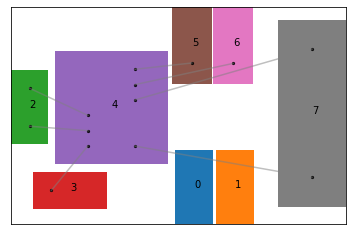

Compiled constraints
                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Jul 20 02:13:01 PM: Your problem has 108 variables, 312 constraints, and 0 parameters.
(CVXPY) Jul 20 02:13:01 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 20 02:13:01 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 20 02:13:01 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 20 02:13:01 PM: Compiling problem (target solver=CBC).
(CVXPY) Jul 20 02:13:01 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -

<Figure size 432x288 with 0 Axes>

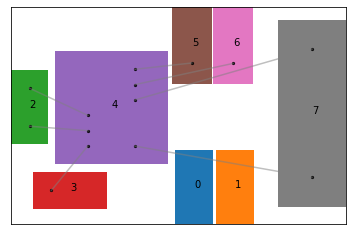

In [9]:
# First, just plot the manual layout (set all components to not be movable / rotateable / no constraints)
boxes = []
horiz_order = []
vert_order = []
for i in range(len(compW)):
    boxes.append(
        Box(
            compW[i],
            compH[i],
            compX[i],
            compY[i],
            initialr=[not r for r in init_Rotation][i],
            initialmx=0,
            initialmy=0,
            idx=i,
            r=False,
            pl=False,
            m=False,
        )
    )
print(len(boxes))
fp = FloorPlan(
    boxes,
    nets,
    adj,
    obj=False,
    norelpairs=None,
    ox=minx,
    oy=miny,
    boundary_W=(maxx - minx),
    boundary_H=(maxy - miny),
    margin=0.5,
    horizontal_orderings=horiz_order,
    vertical_orderings=vert_order,
    max_seconds=3800,
    num_cores=numCores - 1,
    name="test",
)
# fp = FloorPlan(boxes, nets,adj,obj=False,norelpairs=None, ox=minx,oy=miny,boundary_W=(maxx-minx)*3, boundary_H=(maxy-miny)*3,
#                margin=0.5,horizontal_orderings=horiz_order, vertical_orderings=vert_order,
#                max_seconds=3800, num_cores=numCores-1, name="test")
# just show the layout
p,c = fp.layout(solve=False)
print(fp.h.value)
fp.show()
# now solve
plt.clf()
p, c = fp.layout()
print(fp.h.value)
fp.show()

num horizontal & vertical constraints: 7 0
Compiled constraints
                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Jul 20 02:13:05 PM: Your problem has 261 variables, 655 constraints, and 0 parameters.
(CVXPY) Jul 20 02:13:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 20 02:13:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 20 02:13:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 20 02:13:05 PM: Compiling problem (target solver=CBC).
(CVXPY) Jul 20 02:13:05 PM: Re

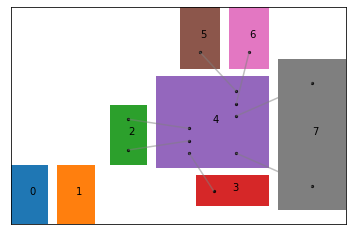

In [10]:
# Now, try making the movable components movable,
# and impose constraints on just the fixed nodes:

# order constraints
vo = []
ho = []

norelpairs = []

for i1, x1 in enumerate(zip(compX, compY)):
    for i2, x2 in enumerate(zip(compX, compY)):
        if i2 <= i1:
            continue
        # one of the two is a fixed node
        if (not movable[i1]) or (not movable[i2]):
            # check horizontal and vertical direction and max difference
            if (
                abs(x1[0] - x2[0]) < abs(x1[1] - x2[1])
                and max(abs(x1[0] - x2[0]), abs(x1[1] - x2[1])) > 10
            ):
                if x1[1] < x2[1]:
                    vo.append([i1, i2])
                else:
                    vo.append([i2, i1])
            else:
                if x1[0] < x2[0]:
                    ho.append([i1, i2])
                else:
                    ho.append([i2, i1])
        else:
            norelpairs.append([i1, i2])

horiz_order = [[boxes[i] for i in h] for h in ho]
vert_order = [[boxes[i] for i in v] for v in vo]
print("num horizontal & vertical constraints:", len(horiz_order), len(vert_order))

boxes = []
for i in range(len(compW)):
    boxes.append(
        Box(
            compW[i],
            compH[i],
            compX[i],
            compY[i],
            initialr=[not r for r in init_Rotation][i],
            initialmx=0,
            initialmy=0,
            idx=i,
            r=movable[i],
            pl=movable[i],
            m=False,
        )
    )

fp = FloorPlan(
    boxes,
    nets,
    adj,
    obj=True,
    norelpairs=None,
    ox=minx,
    oy=miny,
    boundary_W=maxx - minx,
    boundary_H=maxy - miny,
    margin=0.5,
    horizontal_orderings=horiz_order,
    vertical_orderings=vert_order,
    max_seconds=100000,
    num_cores=numCores - 1,
    name="test",
)
p, c = fp.layout()
print("FINAL HPWL: " + str(fp.h.value))
fp.show()